In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2.5 * matplotlib.rcParams['savefig.dpi']
from matplotlib import pylab as plt

In [2]:
import numpy as np
import pandas as pd

import statsmodels.tsa.api as smt
from arch import arch_model
import matplotlib as mpl
import statsmodels.api as sm
import scipy.stats as scs
from scipy import linalg

In [3]:
from statsmodels.tsa.stattools import acf as sm_acf
from statsmodels.tsa.stattools import acovf as sm_acovf
from statsmodels.tsa.stattools import pacf as sm_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox as sm_acorr_ljungbox

# Time Series Analysis

In this notebook, I will work through some models from univariate time series analysis, and apply them to simulated and real datasets. I'll start with a presentation of i.i.d. white noise, and gradually extend the concepts until we reach conditional volatility analysis with GARCH models. I'll assume that the reader is familiar with basic statistics but has no exposure to time series analysis.

### Introduction

In supervised machine learning, the analyst's objective is to discover relationships between independent and dependent variables in a set of example data. We do this in order to learn patterns in the data so that we can generate useful predictions for data yet unseen. Although we may observe a great deal of variability from one sample to the next (noise), we are interested in capturing whatever reproducible behavior might persist as a general rule across all samples (signal). The process involves collecting and sorting data into at least two categories: 1) data that will be used to inform model development and 2) data that will be used to evaluate the model. In the most basic case, we should assemble a training set and a test set.

Textbook examples often create training and test sets by randomly splitting an existing dataset. This approach has some advantages, chief among them the lack of sample bias. Since the training and test sets were randomly selected from the same batch of data, one can be confident that the fundamental relationships between variables underlying both datasets are identical. In the real world, however, it is not always practical to split your data randomly. Time series are one example.

### Time Series Basics

Consider the case of stock price forecasting. Knowing today's price, and in fact the entire history of prices, what can we predict about tomorrow's price? The day after? Can we learn anything at all useful about future prices, given what we know presently? These questions have given rise to the field known as time series analysis.

A time series is a vector of observations, with each observation corresponding to a point in time. Examples include quarterly revenues for a restaurant, the daily high temperature reading at your local airport, an air quality monitor recording hourly NO2 measurements near a freeway, and of course a history of stock daily closing prices. The time intervals are often regular, although this does not need to be the case; for instance, a stock price time series will only include non-holiday weekends when the exchange is open.


### Discrete White Noise

Let's begin by considering a time series where there are no relationships between distinct data points. Here is a series of i.i.d. standard normal random variables:

In [4]:
import numpy as np

np.random.seed(2)
ser_0 = np.random.normal(size=1000)

In [5]:
# Here is a useful visualization function for time series
    # adapted from http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax,linestyle='none',marker='o',markersize=4)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax,alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

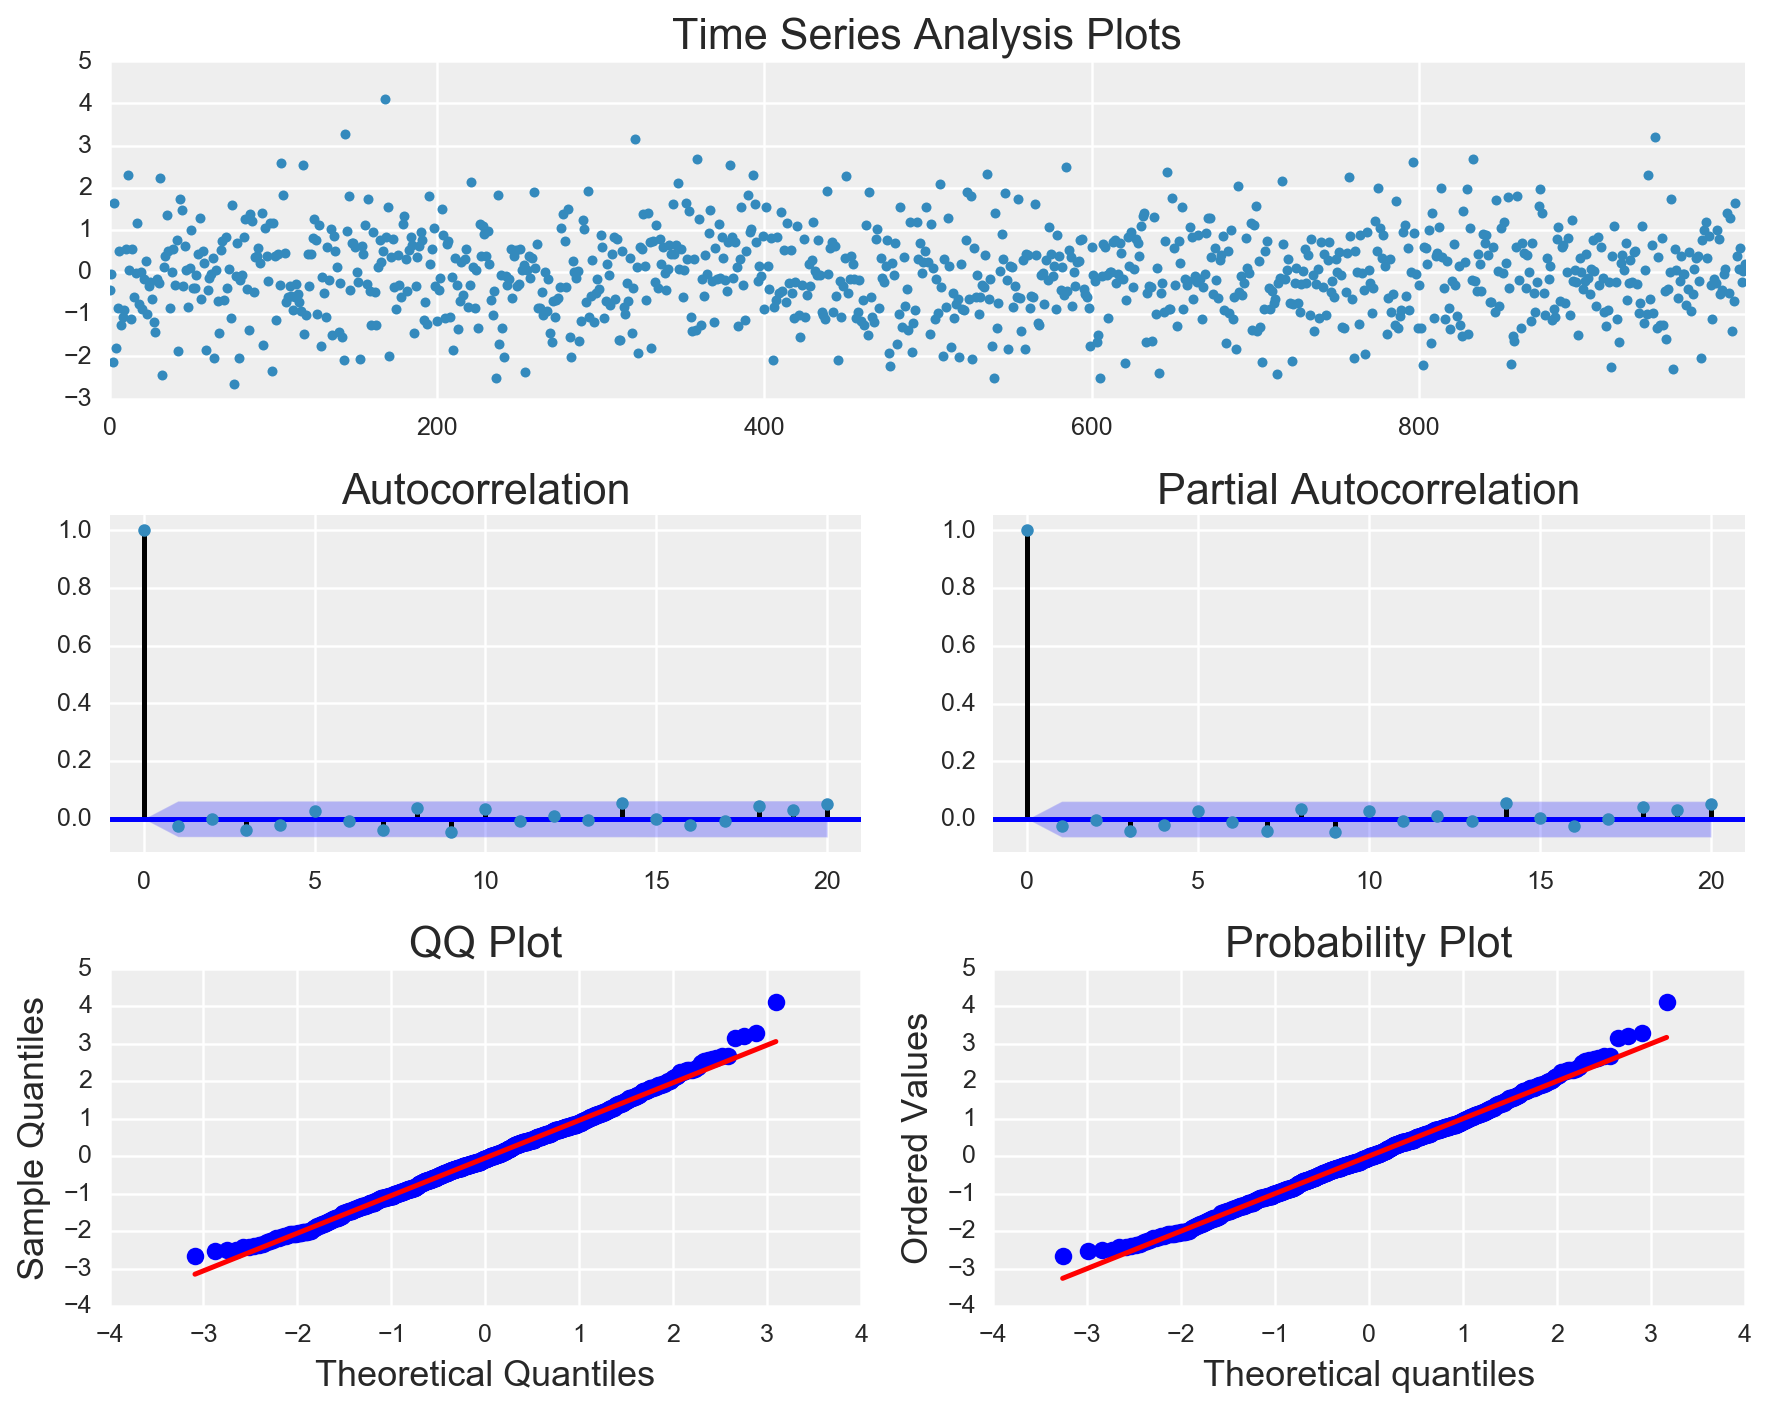

In [6]:
tsplot(ser_0, lags=20)

Successive terms in the TS are independent. No autocorrelations or partial autocorrelations are statistically significant. The scatterplot below shows uncorrelated randomness for any value of $dt \neq 0$ .

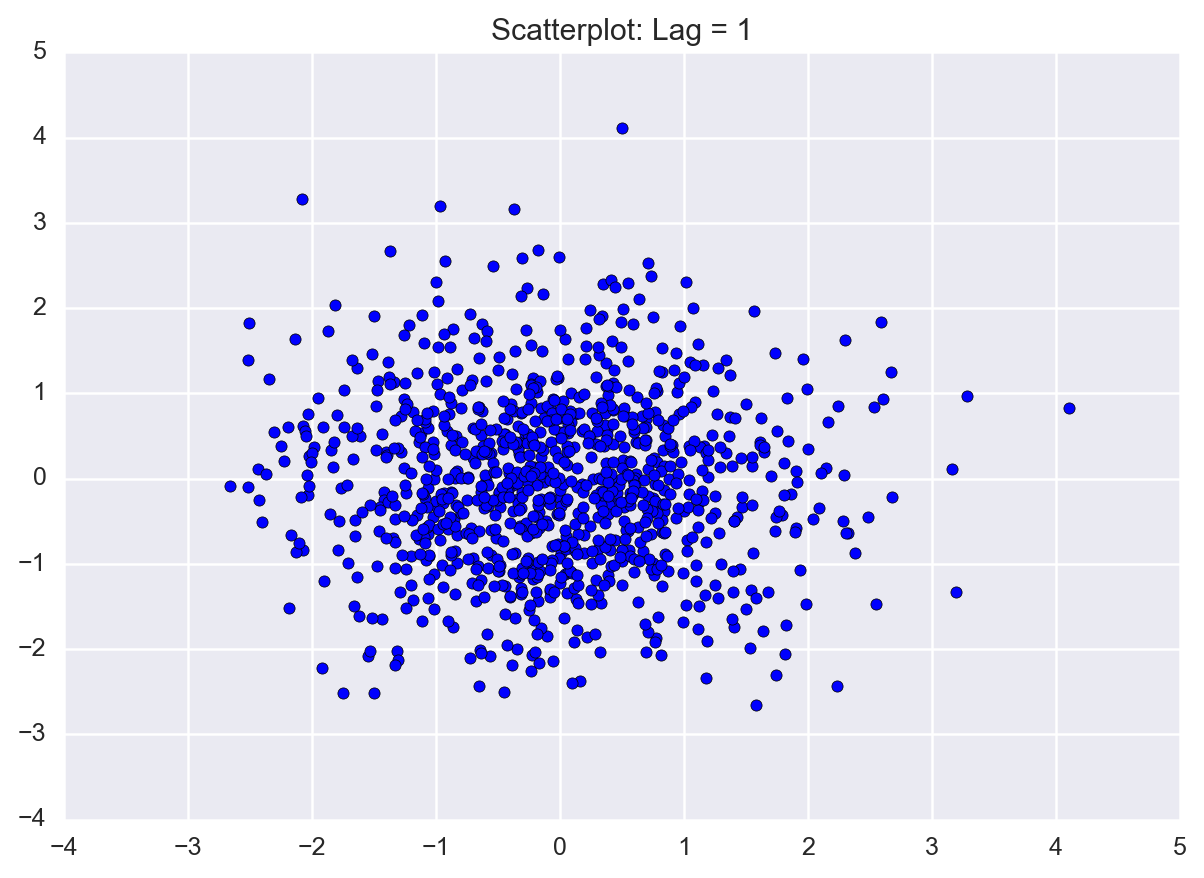

In [7]:
dt=1
X = ser_0[:(-dt or None)]
Y = ser_0[(dt):]
plt.scatter(X,Y)
plt.title('Scatterplot: Lag = %d' % dt)

### Correlation



Correlation of two variables quantifies the predictive power of any linear relationship that may exist between the two.
$\newcommand{\E}{\mathrm{E}}$
$\newcommand{\sd}{\mathrm{sd}}$
$\newcommand{\Var}{\mathrm{Var}}$
$\newcommand{\Cov}{\mathrm{Cov}}$
$\newcommand{\Cor}{\mathrm{Cor}}$
$\newcommand{\absL}{\left\lvert}$
$\newcommand{\absR}{\right\rvert}$
$\DeclareMathOperator{\sign}{sign}$

We begin by defining the covariance between two random variables $X$ and $Y$ as
$$\Cov(X,Y) \equiv \E(XY) - \E(X)\E(Y)$$

Some properties of covariance are immediate consequences of this definition:

1. $\Cov(X,X) = \Var(X)$
1. $\Cov(a X,b X) = a \ b \ \Var(X)$
1. $\Cov(X,Y) = 0$ if $X$ and $Y$ are independent

The first two observations show that the magnitude of covariance scales with the data. We desire a dimensionless metric, so define: 
$$\rho(X,Y) \equiv \frac{\Cov(X,Y)}{\sigma_{X} \sigma_{y}}$$
where $\sigma_{X} = \sd(X) = \sqrt{\Var(X)}$.

Now 

1. $\rho(X,X) = 1$
1. $\rho(a X, b X) = \sign ab$
1. $\rho(X,Y) = 0$ if $X$ and $Y$ are independent

### Auto-Correlation

In time series analysis, we are interested in the relationships between successive observations of a single quantity. The concepts of covariance and correlation extend naturally to time series:

$$\Cov(X_{t},X_{t-h}) \equiv \E(X_{t}X_{t-h}) - \E(X_{t})\E(X_{t-h}) = \E(X_{t}X_{t-h}) - [\E(X)]^2$$

$$\rho_h(X) = \Cor (X_{t},X_{t-h}) \equiv \frac{\Cov(X_{t},X_{t-h})}{\sigma_{X_{t}} \sigma_{X_{t-h}}} = \frac{\Cov(X_{t},X_{t-h})}{[\sigma_{X}]^2}$$

Here, $h$ refers to the delta in time steps. The notation for autocorrelation function is often simplified to $\rho(h)$.

In real data we won't know the underlying distribution exactly, so we must examine samples to estimate the underlying relationships. The sample auto-covariance function is:
$$\hat{\gamma}(h) \equiv \frac{1}{n-h} \; \sum_{j=h+1}^{n} (X_j - \hat{\mu})*(X_{j-h} - \hat{\mu}) \hspace{3em} \textrm{unbiased version}$$
$$\hat{\gamma}(h) \equiv \frac{1}{n} \; \sum_{j=h+1}^{n} (X_j - \hat{\mu})*(X_{j-h} - \hat{\mu}) \hspace{3em} \textrm{biased version}$$
where $n$ is the total number of samples and $\hat{\mu}$ is the sample mean $\bar{X}$.

To obtain sample correlation, one divides sample covariance by the sample variance $\hat{\sigma^2}$, again expressing the strength of the relationship between the two quantities as a fraction of the overall variance in the sample. Since $\hat{\sigma^2} = \hat{\gamma}(0)$ by definition, then $\hat{\rho}(0) = 1$.

In [8]:
# write my own acf:
def rek_acf(series,lags=5,unbiased=True): 
    n=len(series)
    autocorrelations = np.zeros(1+lags)
    series = series-np.mean(series)  # DEMEAN
    for lag in range(0,1+lags):
        X = series[:(-lag or None)]
        Y = series[(lag):]
        assert(len(X)==len(Y))
        covXY = np.mean(X*Y) - (np.mean(series))**2
        corXY = covXY / (np.var(series))
        # Note that covXY and corXY get mean and var from full series, not from mean(X)*mean(Y)
        if (unbiased==False):
            corXY *= (n-lag)/float(n)
        autocorrelations[lag] = corXY
    return autocorrelations

In [9]:
print(rek_acf(ser_0,lags=10,unbiased=True))
print(rek_acf(ser_0,lags=10,unbiased=False))

[ 1.         -0.02369908 -0.00170053 -0.04028983 -0.02023877  0.02788191
 -0.00875924 -0.04079471  0.0366087  -0.04755215  0.033672  ]
[ 1.         -0.02367538 -0.00169713 -0.04016896 -0.02015782  0.0277425
 -0.00870669 -0.04050915  0.03631583 -0.04712418  0.03333528]


In [10]:
print(rek_acf(ser_0,lags=30,unbiased=True)/sm_acf(ser_0,unbiased=True,nlags=30))
print(rek_acf(ser_0,lags=30,unbiased=False)/sm_acf(ser_0,unbiased=False,nlags=30))
# Verified: Matches the statsmodels acf computation

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


Why two versions of the ACF: biased and unbiased?

There is no universal convention for the denominator. The ACF with $n$ in the denominator is always biased. But the ACF with $n-h$ in the denominator, which may appear to be unbiased due to there being $n-h$ terms in the sum,  is often not unbiased either (i.e. whenever the population mean is unknown and a sample mean is used to estimate it). Although a blanket referral to this version as 'unbiased' is an oversimplication, the word 'unbiased' is nevertheless often used to describe this version. On the other hand, the biased version does have some useful statistical properties, so it is actually used more often.

Regardless, for $h << n$, the two versions converge to each other. For most analysts investigating time series datasets to learn about variables of interest, it will not matter which version is used.

More information on the topic of biased vs. unbiased ACF:
1. [statsmodels' documentation](http://www.statsmodels.org/dev/_modules/statsmodels/tsa/stattools.html#acf)
1. [NIST/SEMATECH e-Handbook of Statistical Methods](http://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm)
1. [The Analysis of Time Series - An Introduction. 6th ed. Chris Chatfield](https://github.com/zixiaojindao/time-series-survey/blob/master/time%20series/The%20Analysis%20of%20Time%20Series%20-%20An%20Introduction%206ed_Chris%20Chatfield.pdf)


In [11]:
# ratio between biased and unbiased versions = (n-k)/n
print(rek_acf(ser_0,lags=9,unbiased=False)/rek_acf(ser_0,lags=9,unbiased=True))

[ 1.     0.999  0.998  0.997  0.996  0.995  0.994  0.993  0.992  0.991]


### Ljung-Box test:

The sample auto-correlation of an i.i.d. random process auto-correlations will not be exactly zero due to noise. One may encounter a time series and wish to assess whether the observed sample auto-correlation is due to signal (an underlying property of the process that generated the dataset) or noise (random variation). Thus it is useful to devise a statistical test to answer this question. 

It is desirable to consider the entire ACF in such a test, because a true signal could cause deviation away from uncorrelated noise at any lag. Thus [Ljung and Box](https://doi.org/10.1093%2Fbiomet%2F65.2.297) devised a [portmanteau test](https://en.wikipedia.org/wiki/Portmanteau_test) that would simultaneously consider all lags from unity up to a specific maximum in a single test. The null hypothesis $H_0$ is that the underlying process is i.i.d.

The Ljung-Box test statistic 
$$Q(k) = n (n+2) \sum_{j=1}^k \frac{{\rho_j}^2}{n-j} $$

for the first $k$ lags follows a chi-square distribution if the null hypothesis is true. The associated $p$-value from the chi-square distribution indicates the likelihood that one would obtain a $Q$ greater than or equal to the observed value when the true underlying distribution is actually uncorrelated noise.

In [12]:
        # G. M. Ljung; G. E. P. Box (1978). "On a Measure of a Lack of Fit in Time Series Models". 
                # Biometrika. 65 (2): 297–303.  https://doi.org/10.1093%2Fbiomet%2F65.2.297
def rek_LjungBox(series,lags):
    n=len(series)
    jj = np.arange(1,1+lags) # lags
    Q_jj = n*(n+2) * ((rek_acf(series,lags,unbiased=False)[1:])**2) / (n-jj)
    Q = np.cumsum(Q_jj)
    pValues = 1-scs.chi2.cdf(Q,jj)
    return (Q,pValues)

The Ljung-Box function returns two vectors: the $Q$ and $p$ values, where each pair of entries $Q(j)$ and $p(j)$ corresponds to a given max-lag $j$. The Q statistic is a cumulative sum. Since it is necessary to compute $Q(j)$ for all $j \leq k$, it is therefore trivial to return that information in the output. However, when analyzing the test, one should only consider the max-lag $k$, i.e. the last Q and p. This will describe how probable the entire combination of auto-correlations between lags $1$ and $k$ is. 

In [13]:
[rekQ,rekP] = rek_LjungBox(ser_0,lags=30)
[smQ,smP] = sm_acorr_ljungbox(ser_0,lags=30)
print(rekQ/smQ)
print(rekP/smP)
# Verified: this computation matches statsmodels' implementation of Ljung-Box test

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


Ljung-Box test output for our white noise series:

In [14]:
rek_LjungBox(ser_0,lags=30)

(array([  0.56220709,   0.5650989 ,   2.18673599,   2.59552133,
          3.37058234,   3.44699887,   5.10286315,   6.43499741,
          8.68033506,   9.80504541,   9.86834628,   9.96450935,
          9.99372364,  12.97286198,  12.97371521,  13.45110591,
         13.52734342,  15.39018782,  16.31886651,  19.09646588,
         23.15537021,  23.26676638,  23.38514664,  24.13050465,
         24.13413151,  27.24317634,  27.60585145,  27.60647087,
         27.8146555 ,  28.812571  ]),
 array([ 0.45337234,  0.75385936,  0.53456569,  0.62761671,  0.6430541 ,
         0.75100739,  0.64741185,  0.59862642,  0.46728977,  0.45776074,
         0.54226704,  0.61907435,  0.69444753,  0.52866162,  0.60432825,
         0.63953252,  0.70023097,  0.63502423,  0.63590832,  0.51556381,
         0.33575064,  0.38679956,  0.43847785,  0.45415522,  0.51163439,
         0.3966688 ,  0.43150335,  0.48544064,  0.52783879,  0.52745813]))

This input data set is white noise, so the result is not surprising. The max-lag $p$-value is roughly $0.5$ so this result is very typical for white noise. A Ljung-Box test at any reasonable level of significance would fail to reject $H_0$.

We can ask: as a function of $k$, what $Q(k)$ would be required to reject $H_0$ at level of significance $\alpha = 0.05$? In other words, what value of the Ljung-Box test statistic $Q$ would correspond to a $p$-value of $0.05$?

Since we know that the process behind the null hypothesis produces a chi-square distribution on $Q(k)$, this is an easy computation:

In [15]:
alpha = 0.05
numLags = 30
scs.chi2.ppf(1-alpha,np.arange(1,1+numLags))

array([  3.84145882,   5.99146455,   7.8147279 ,   9.48772904,
        11.07049769,  12.59158724,  14.06714045,  15.50731306,
        16.9189776 ,  18.30703805,  19.67513757,  21.02606982,
        22.36203249,  23.6847913 ,  24.99579014,  26.2962276 ,
        27.58711164,  28.86929943,  30.14352721,  31.41043284,
        32.67057334,  33.92443847,  35.17246163,  36.4150285 ,
        37.65248413,  38.88513866,  40.11327207,  41.33713815,
        42.5569678 ,  43.77297183])

If we were to run the preceding simulation many times, we should expect to see the output $p$-values uniformly distributed on $(0,1)$. (If this were not the case, then by definition of $p$-value, we must be calculating it incorrectly!)

For a given simulated TS, the $p$-values at two different lags $i$ and $j$ are strongly correlated, especially for $i$ close to $j$, since they use the same data and the Q statistic is a cumulative sum. But across many different simulated series, the $p$-values computed for any given lag should follow the uniform distribution.

Let's test that:

In [44]:
# run-time ~ 5 seconds:

np.random.seed(333)
N = 10000 # runs
seriesLength = 1000 
nLags = 30 # lags
pValues = np.zeros((N,nLags))
randomMatrix = scs.norm.rvs(size=(N,seriesLength))
for run in range(N):
    mySeries = randomMatrix[run]
    assert(len(mySeries)==seriesLength)
    (_,thisP) = sm_acorr_ljungbox(mySeries,lags=30)
    pValues[run,:] = thisP

In [59]:
pValues

array([[ 0.52904608,  0.37614551,  0.58027094, ...,  0.10478545,
         0.11271384,  0.13817812],
       [ 0.04892586,  0.09827537,  0.06306357, ...,  0.03860606,
         0.04157873,  0.03576811],
       [ 0.81833616,  0.57443149,  0.61362521, ...,  0.88509611,
         0.887526  ,  0.89458441],
       ..., 
       [ 0.59615303,  0.10561567,  0.20446969, ...,  0.01550111,
         0.02057096,  0.01820754],
       [ 0.70578797,  0.93091942,  0.13194477, ...,  0.51636867,
         0.56978758,  0.62082439],
       [ 0.38448155,  0.25548347,  0.34621724, ...,  0.33496404,
         0.38225281,  0.37862288]])

The correlation between nearby lags in each resultant $p$ vector is obvious just from the limited subset of entries displayed here. Of the six trials that are partially displayed, two of them would be rejected at 5% significance. (Remember that our significance test only considers the last element of each vector.) We should expect that to occur in only 5% of the trials, so it is a bit concerning that it occurs in two out of these six rows.

Given uniformly distributed $p$-values, what is the probability that two or more out of six observed would fall below $0.05$?

In [53]:
from scipy.misc import comb
(nTrials,nSignif) = (6,2)
alpha = 0.05
print(sum([((comb(nTrials,k))*(alpha**k)*((1-alpha)**(nTrials-k))) for k in range(nSignif,nTrials+1)]))

0.032773828125


The result is a small probability but not so small; perhaps it could have occurred by chance?

The following scatter chart shows the distribution of $p$-values for a given lag, across all runs. It does look like a uniform distribution!

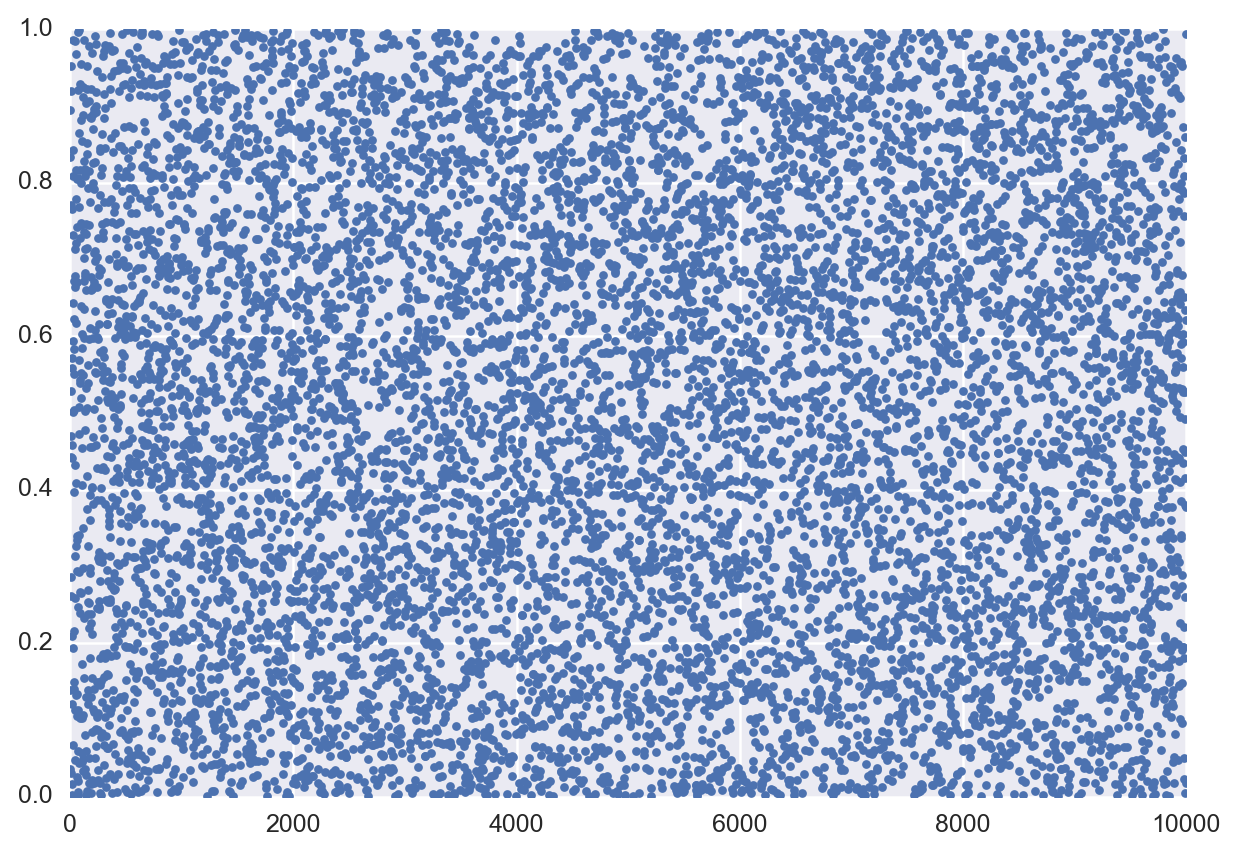

In [56]:
myLag = nLags-1
plt.plot(pValues[:,myLag],'.')
# second index 0 =====> p-value for single-lag test
            # nLags-1 =====> p-value for complete portmanteau test

Of course, we can also test the uniformity of this distribution:

In [58]:
scs.kstest(pValues[:,myLag], 'uniform')

KstestResult(statistic=0.0084350421885585058, pvalue=0.47524030052133714)

A one-sample two-sided Kolmogorov-Smirnov test gives a $p$-value near 0.5. Our results are indeed consistent with a uniform distribution!

### Auto-Regressive Models: AR(1)

An understanding of white noise is a necessary starting point, but most temporal phenomena of interest have relationships between different observations. Stock prices, temperature observations, airline passenger counts, and traffic fatalities are examples of phenomena for which models will need to characterize trends and correlations between observations, not just an overall average. For a time series $Y$, we wish to be able to characterize the probability distribution of the next observation, given the preceding observations.

In the white noise case, with no correlations between observations, the cumulative distribution function for the next observation $F(Y)$ is independent of prior data. So the conditional distribution of $F(Y_t \; |  \; Y_{t-1},Y_{t-2},...Y_1)$ is simply equal to its marginal distribution $F(Y)$, i.e. knowing the history doesn't help you to make a better prediction on the next value.

Let us now consider our first example where this is not the case. Let $Y$ be generated by a linear regression on one prior value plus a noise term:

$$ Y_t = \phi * Y_{t-1}  + b + \epsilon_t $$
where $\phi$ and $b$ are regression constants, and $\epsilon_t$ is an uncorrelated white noise process, with mean zero and variance ${\sigma_\epsilon}^{2}$. The noise process could be, but is not necessarily, Gaussian. The resulting process is a first-order autoregressive time series, or AR(1).



Let's inspect such a series for several values of $\phi$ and $b$ to see how these parameters affect its behavior.

In [ ]:
def makeAR1Series_from_b_phi(n,b,phi):
    epsilon=np.random.normal(size=n)
    ser = np.zeros(n) # just preAllocating space
    ser[0] = epsilon[0]
    for i in range(1,n):
        ser[i] = phi*(ser[i-1]) + b + epsilon[i] 
    return ser

In [ ]:
n=500
vecB = [-5,+5]
vecPhi = [+0.1,-0.1,+0.5,-0.5,+0.9,-0.9,+1.0,-1.0,+1.1,-1.1,+1.5,-1.5]
with plt.style.context('bmh'):
    fig = plt.figure(figsize=(20,40))
    layout = (len(vecPhi),len(vecB))
    plotTuples = [(p1,p2) for p1 in range(len(vecPhi)) for p2 in range(len(vecB))]
    axisHandles = [[0 for _1 in range(len(vecB))] for _2 in range(len(vecPhi))]
    for pT in plotTuples:
        (p1,p2)=pT
        axisHandles[p1][p2] = plt.subplot2grid(layout,(p1,p2))
        y = pd.Series(makeAR1Series_from_b_phi(n,vecB[p2],vecPhi[p1]))
        y.plot(ax=axisHandles[p1][p2], linestyle='-', marker='o', markersize=4)
        axisHandles[p1][p2].set_title('phi=%3.1f, b=%3.1f' % (vecPhi[p1],vecB[p2]))
    plt.tight_layout()

Observations:

1. For $\absL \phi \absR < 1$, the time series converges around a long-term average value.
1. In general, these series are not initialized at their long-term averages, so there is a short correction period at the beginning before the long-term behavior emerges. The most pronounced example of this occurs when $\phi=+0.9$, but even here it reaches its average in about 30 steps. 
1. For $\absL \phi \absR > 1$, the time series explodes exponentially. 
1. For $\absL \phi \absR = 1$, things are a bit more complicated. For $\phi=+1$, the time series diverges linearly with slope $b$. For $\phi=-1$, the series has significant variance but seems stable enough to remain near zero in the long run.
1. For $\absL \phi \absR > 1$ and $\phi=1$, the Gaussian noise has been so overwhelmed by the drift that it is impossible to see any influence of randomness in these figures.

#### Stationary AR(1) models


It can be shown that a first-order auto-regressive time series will be stationary if and only if $\absL \phi \absR < 1$. If $\phi = 1$, the process is a random walk that drifts with no central tendency. If $\phi=-1$, the process is stable but not stationary, because

For $\phi > 1$, the AR process explodes.


A change of variables can be useful. Whenever $\phi \neq 1$, we can re-write this linear regression relationship as

$$ Y_t = \mu + \phi ( Y_{t-1} - \mu) + \epsilon_t$$

where $\phi$ and $\mu$ are now the regression coefficients. ($\mu = \frac{b}{1-\phi}$)





We are most interested in stationary models. Some general properties of a stationary AR(1) model:

1. $\E(Y_t) = \mu$
1. $\Var(Y_t) = \frac{{\sigma_\epsilon}^2}{1-\phi^2}$
1. $\rho(h) = \phi^{\left\lvert h \right\rvert}$

Example: here is how $\E(Y_t)$ is calculated. The other expressions are derived similarly.

$$\E(Y_t) = \E(\mu + \phi ( Y_{t-1} - \mu) + \epsilon_t)$$
$$ = \mu + \phi \E(Y_{t-1}) - \phi \mu + \E(\epsilon_t) $$ 
$$ = \mu + \phi \E(Y_t) - \phi \mu + 0$$

where we have used that $E(Y_{t-1}) = E(Y_t)$ due to stationarity of the marginal distribution, and $\E(\epsilon_t) = 0$ since the noise process is zero-mean.  Solving for $\E(Y_t)$ gives $\mu$.



We shall simulate a series that follows this relationship:

In [ ]:
def generateSeries_AR1(n,mu,phi):
    epsilon=np.random.normal(size=n)
    ser = np.zeros(n) # just preAllocating space
    ser[0] = mu + epsilon[0]
    for i in range(1,n):
        ser[i] = mu + phi*(ser[i-1]-mu) + epsilon[i] 
    return ser

In [ ]:
np.random.seed(7)
[n,mu,phi] = [1000,0.0,0.95]
ser_AR1 = generateSeries_AR1(n,mu,phi)

In [ ]:
plt.plot(ser_AR1,'.')

The TS is obviously no longer i.i.d. Observations tend to occur close to previous observations. We can visualize this with a scatterplot of the TS against a lagged version of itself. 

In [ ]:
myLag = 1
plt.scatter(ser_AR1[:(-myLag or None)],ser_AR1[myLag:])

Below are the tsplot visualizations:

In [ ]:
tsplot(ser_AR1,lags=20)

Questions:

1. For a given time series, how does the TS auto-correlation scatterplot change as you vary the lag? Do you see a pattern? 
1. How does this relate to the Autocorrelation figure?

We could run a linear regression on the lag=1 relationship:

In [ ]:
# OLS linear regression: Y = beta*X + eps 
        # where the X term includes an X_0 === 1 (so beta_0 is intercept)
        # eps is the noise term
order=1
(X,Y) = (ser_AR1[:(-order or None)].reshape(n-order,1),ser_AR1[order:].reshape(n-order,1))
xX = np.concatenate((np.ones((X.shape[0],1)),X),axis=1) # add an intercept term, (it's a trivial feature vector: all ones)
beta = np.dot(np.linalg.inv(np.dot(xX.T,xX)),np.dot(xX.T,Y)) # matrix computation for exact solution to OLS linear regression
print(beta)

print(rek_acf(ser_AR1,lags=4,unbiased=True))
print(sm_acf(ser_AR1,nlags=4,unbiased=True))
print(rek_acf(ser_AR1,lags=4,unbiased=False))
print(sm_acf(ser_AR1,nlags=4,unbiased=False))

Let's run a Ljung-Box test on the series:

In [ ]:
rek_LjungBox(ser_AR1,lags=30)
#sm_acorr_ljungbox(ser_AR1,lags=30)
        # these two calculations match exactly (although sm is slower b/c it computes entire acf before truncating!)

The Ljung-Box $Q$-statistic is so large that the $p$-values are essentially zero. Obviously not white noise!

Now let's subtract out the regression fit to the series. We want to see if the residuals look like white noise. We will use the regression fit parameters, not the underlying $\mu$ and $\phi$ that were used to generate the series.

In [ ]:
Z = Y - np.dot(xX,beta)
# plt.plot(Z,'.')  # looks like white noise
rek_LjungBox(Z,lags=30) # Q-statistic is low and p-values are large, so we would not reject H0

The residuals do look like white noise! This tells us that our regression model could explain the phenomenology of this TS.

### Partial Auto-correlation

The tsplot method shows a function called partial autocorrelation (PACF) as well as the standard autocorrelation function (ACF). 
As we discovered above, our auto-regressive series shows auto-correlation at lags well beyond the single lag that is regressed on explicitly. For an AR(1) series, $\rho(h) = \phi^{\left\lvert h \right\rvert}$, so the correlation extends to infinitely many lag terms, albeit diminishing toward zero for large lags.

The PACF, however, shows a strong correlation at lag $= 1$ and then disappears for lags $2$ and above. PACF at lag $h$ controls for the computed autocorrelations for all lags $< h$ and then gives any additional correlation that persists beyond that.

PACF is NOT the same as the ACF of the residuals after fitting an AR($h$) model:


In [ ]:
# Look at the acf of the residuals. Is that the same thing as pacf?

In [ ]:
print(rek_acf(Z,lags=5,unbiased=True))
print(rek_acf(Z,lags=5,unbiased=False))
print(sm_acf(Z,nlags=5, unbiased=True))
print(sm_acf(Z,nlags=5, unbiased=False))

In [ ]:
print(sm_pacf(ser_AR1,nlags=5,method='ywunbiased'))
print(sm_pacf(ser_AR1,nlags=5,method='ywmle'))
print(sm_pacf(ser_AR1,nlags=5,method='ols'))   # sm documentation claims there is an error with pacf ols ?
print(' ')
print(sm_acf(ser_AR1,nlags=4,unbiased=True))
print(sm_acf(ser_AR1,nlags=4,unbiased=False)) 

The auto-correlation of the residuals is not the same as PACF.

Note that the lag 1 term does match, however. This is expected because there are no correlations to control for with lags less than 1. Using Yule-Walker unbiased matches ACF unbiased at lag 1, while Yule-Walker MLE matches ACF biased at lag 1.

PACF at lag 2, however is 
$$ \mathrm{PACF}(2) = \frac{\E(X_0 X_2 \; | \; X_1)}{\sigma(X_0 \, | \, X_1) \; \sigma(X_2 \, | \, X_1)}$$

In [ ]:
# No. The autocorrelation of the residuals is not the same as pacf, even in the lag=2 term.
    # The lag=1 term does match
            # PACF ywunbiased at lag=1 matches ACF unbiased at lag=1
            # PACF ywmle at lag=1 matches ACF biased at lag=1

# pacf at lag2 is (E(X0*X2 | X1)) / (sd(X0|X1)*sd(X2|X1)) 

In [ ]:
print(sm_acf(ser_AR1,nlags=1,unbiased=True)[1],sm_pacf(ser_AR1,nlags=1,method='ywunbiased')[1])
print(sm_acf(ser_AR1,nlags=1,unbiased=False)[1],sm_pacf(ser_AR1,nlags=1,method='ywmle')[1])
# The lag=1 terms do agree 

In [ ]:
# Let's follow the Yule-Walker method and reproduce pacf:
    # https://stats.stackexchange.com/questions/129052/acf-and-pacf-formula
    
def rek_pacf(series,lags=5,unbiased=True):
            # let this function do both yule-walker pacfs: (unbiased=>ywunbiased, biased=>ywmle)
    my_acf = rek_acf(series,lags,unbiased=unbiased)
    my_pacf = np.ones(lags+1)
    for l in range(1,lags+1):   
        autocorMtx = linalg.toeplitz(my_acf[:l])
        my_pacf[l] = np.dot(linalg.inv(autocorMtx),my_acf[1:(l+1)])[-1]
    return(my_pacf)

# Since matrix is symmetric toeplitz, one could compute faster with Levinson recursion rather than linalg.inv
    # O(n^2) vs O(n^3)
    # https://en.wikipedia.org/wiki/Levinson_recursion
    # but I won't be considering large lags anyway, so n is pretty small and I won't worry about this

In [ ]:
my_acf = rek_acf(ser_AR1,lags=2,unbiased=True)
M = linalg.toeplitz(my_acf[:-1])
pacf_2 = np.dot((linalg.inv(M)),my_acf[1:])
print(pacf_2)
# now the lag2 term matches sm_pacf (ywunbiased) 
    # but not the lag 1 term. You have to recompute entire vector for each lag you're interested in!
        # (and then read off the last element)

In [ ]:
print(rek_pacf(ser_AR1,lags=5,unbiased=True))
print(rek_pacf(ser_AR1,lags=5,unbiased=False))

In [ ]:
print(rek_pacf(ser_AR1,lags=5,unbiased=True)/sm_pacf(ser_AR1,nlags=5,method='ywunbiased'))
print(rek_pacf(ser_AR1,lags=5,unbiased=False)/sm_pacf(ser_AR1,nlags=5,method='ywmle'))
# Verified: this version of PACF matches statsmodels' computation of PACF, fow ywunbiased and ywmle cases

In [ ]:
# Okay now let's look at a general AR series

In [ ]:
def rek_generateSeries_AR(n,mu,phi):
    # n === number of points
    # mu === mean of series
    # phi === vector of AR coeffs (len(phi) = series order)
    epsilon=np.random.normal(size=n)
    phiRev = phi[::-1]
    ser = np.zeros(n)
    ser[0] = mu + epsilon[0]
    for i in range(1,len(phi)):
        ser[i] = epsilon[i] + mu + np.dot(phiRev[-i:],ser[:i]-mu)
    for i in range(len(phi),n):
        ser[i] = epsilon[i] + mu + np.dot(phiRev,ser[(i-len(phi)):i]-mu)
    return ser

In [ ]:
np.mean(ser_AR1)

In [ ]:
np.random.seed(28)
serTest = rek_generateSeries_AR(100000,0,[0.95])

In [ ]:
np.mean(serTest) # with same seed, same AR1 series is generated

In [ ]:
# Aside: I was concerned about the distribution of noise terms, so generated a trivial AR series with all arguments zero.
# For a small number of runs, the plots appeared to show far too many extreme negative values in the series
        # compared to what would be expected for a normal distribution
# For a larger sample, however, it does look close enough.
# RT: ~5s
numLessThanMinus3 = 0
runsHere = 2000
NNNN=1000
for _ in range(runsHere):
    np.random.seed(_)
    serTest = rek_generateSeries_AR(NNNN,0,[0.0]) # WN
    numLessThanMinus3 += np.count_nonzero(serTest<-3)
print((numLessThanMinus3),NNNN*runsHere*scs.norm.cdf(-3))

In [ ]:
# Let's compare several AR-2 series :
np.random.seed(9)
serTest_A = rek_generateSeries_AR(10000,0.0,[0.9+0.99,-0.9*0.99])  # roots of characteristic polynom = [0.9,0.99] -> stationary
plt.plot(serTest_A,'.')
serTest_B = rek_generateSeries_AR(10000,0.0,[0.9+1.00,-0.9*1.00])  # one root is a unit root. -> random-walk type behavior
plt.plot(serTest_B,'.')
serTest_C = rek_generateSeries_AR(10000,0.0,[0.5+1.01,-0.5*1.01])  # one root has magnitude > 1. -> explosive behavior
#plt.plot(serTest_C,'.') # blows up rapidly , so remove it from the plot

In [ ]:
# Let's look at an AR-2 series

In [ ]:
np.random.seed(222)
(N,mu,phi) = (100000,0,[1.4,-0.45]) # roots of characteristicPoly are 0.5 and 0.9
ser_AR2 = rek_generateSeries_AR(N,mu,phi)

In [ ]:
plt.plot(ser_AR2[:2000],'.')

In [ ]:
tsplot(ser_AR2[:1000],lags=30)
# PACF clearly suggests that a second-order AR model is a possible match for this time series

In [ ]:
# Aside: numpy has some useful polynomial functions:
    # np.polynomial.polynomial.polyfromroots(myRoots) computes coeffs of a polynomial from its roots
    # np.roots(P) computes the roots from the polynomial coeffs
    # but for some reason, the input polynomial is high-to-low order for np.roots() 
                    # while the output polynomial is low-to-high order for polyfromroots()
        # so you have to flip the coeffs, or else you'll get the reciprocals of original roots
    

myRoots = [2,3,0]
myPolynomial = np.polynomial.polynomial.polyfromroots(myRoots)
print(myPolynomial)
againRoots_rev = np.roots(myPolynomial)   # poly reversal => lower order, b/c one of the roots was a zero
print(againRoots_rev)
againRoots_forward = np.roots(myPolynomial[::-1])
print(againRoots_forward)

myRoots = [0.9,0.9,0.8,0.4+0.3j,0.4-0.3j]
myPolynomial = np.polynomial.polynomial.polyfromroots(myRoots)[::-1]
againRoots_v1 = np.roots(myPolynomial)
print(againRoots_v1)

# If you expect real coeffs, it can be helpful to force that explicitly to reduce computational errors:
myRoots = [0.9,0.9,0.8,0.4+0.3j,0.4-0.3j]
myPolynomial = np.polynomial.polynomial.polyfromroots(myRoots).real[::-1]
againRoots_v2 = np.roots(myPolynomial)
print(againRoots_v2)

In [ ]:
# Now let's look at an AR-5 series:

np.random.seed(555)
myRoots = [0.9,0.9,0.8,0.4+0.3j,0.4-0.3j]  # make the poly terms real-valued by including conjug for any cplx number
phiVector = -1*(np.polynomial.polynomial.polyfromroots(myRoots)).real[:-1][::-1]
    # https://en.wikipedia.org/wiki/Autoregressive_model (condition for a "wide-sense" stationary model: abs(eachRoot)<1
    # https://www2.stat.duke.edu/~km68/materials/214.8%20(ARp).pdf   (author = Kai Mao?)
(N,mu,phi) = (100000,0,phiVector) 
ser_AR5 = rek_generateSeries_AR(N,mu,phi)

In [ ]:
plt.plot(ser_AR5[:2000],'.')

In [ ]:
tsplot(ser_AR5[:1000],lags=20)

In [ ]:
# PACF shows that an AR model is a good match.
# But it's difficult to identify exactly what order the series should be.
    # Note that the PACF at lag=5 is well inside the error bounds.
    

In [ ]:
# Okay, now let's look at MA models.

def rek_generateSeries_MA(n,mu,theta):
    # n === number of points
    # mu === mean of series
    # theta === vector of MA coeffs (len(theta) = MA order).   Coeff on eps_0 is always one.
    epsilon=np.random.normal(size=n)
    thetaRev = theta[::-1]
    ser = np.zeros(n)
    ser[0] = mu + epsilon[0]
    for i in range(1,len(theta)):
        ser[i] = epsilon[i] + mu + np.dot(thetaRev[-i:],epsilon[:i])
    for i in range(len(theta),n):
        ser[i] = epsilon[i] + mu + np.dot(thetaRev,epsilon[(i-len(theta)):i])
    return ser

In [ ]:
np.random.seed(1534)
ser_MA7 = rek_generateSeries_MA(100000,0,[1,1,1,1,1,1,1])
np.random.seed(1536)
ser_MA6 = rek_generateSeries_MA(100000,0,[1,1,1,1,1,1])

In [ ]:
plt.plot(ser_MA7[:1000],'.')

In [ ]:
tsplot(ser_MA7[:1000],lags=20)

In [ ]:
# To identify a MovingAverage model, the ACF is more useful than PACF.
# MA is a finite impulse-response series, so there should be zero correlation at lags >= the theta-vector length (7)
# In this case, the last statistically significant ACF lag is 7, as expected.
    # Note however that since AR coeffs drop steadily, it can be difficult to identify the length of a longer MA series 
    # Coeff Theta7 is just above the standard error
# PACF has large values at lags=[1,9,17]

In [ ]:
tsplot(ser_MA6[:1000],lags=20)

In [ ]:
# Same behavior in ACF and PACF (now large PACF at lags=[1,8,15])

In [ ]:
# Let's investigate our synthetic series using a standard ARIMA approach
    # Choose limits for p,d,q
        # Since we know that the series are zero-mean, we expect d=0 for all these series
    # Choose model decision criterion (AIC vs. BIC)
        # BIC will choose a more parsimonious model, AIC will prefer a model with slightly more training-set accuracy

In [ ]:
# RT: ~20min

# Fit ARIMA(p, d, q) model to ser_AR1 Returns

# pick best order and final model based on aic, bic

best_aic_serar1 = np.inf
best_bic_serar1 = np.inf
bestFit_aic_serar1 = None
bestFit_bic_serar1 = None

pq_rng = range(6) # [0,1,2,3,4,5,6,7,8]
d_rng = range(1) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(ser_AR1, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                tmp_bic = tmp_mdl.bic
                print((i,d,j,tmp_aic,tmp_bic))
                if tmp_aic < best_aic_serar1:
                    best_aic_serar1 = tmp_aic
                    bestFit_aic_serar1 = ((i,d,j),tmp_mdl)
                if tmp_bic < best_bic_serar1:
                    best_bic_serar1 = tmp_bic
                    bestFit_bic_serar1 = ((i,d,j),tmp_mdl)
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic_serar1, bestFit_aic_serar1[0]))
print('bic: {:6.5f} | order: {}'.format(best_bic_serar1, bestFit_bic_serar1[0]))


# ARIMA model resid plot
# _ = tsplot(best_mdl.resid, lags=30)

In [ ]:
best_mdl = bestFit_aic_serar1[1]
# ARIMA model resid plot
tsplot(best_mdl.resid, lags=20)

In [ ]:
# Looks great. There is no correlation between the residuals after fitting ARIMA(1,0,0)

In [ ]:
# But that took 20 minutes, so let's reduce N when looking at our other synthetic time series.
    # Just the first 10k points in the others, but we'll increase test (p,q) max to 8

In [ ]:
# RT: ~20min

# Fit ARIMA(p, d, q) model to ser_AR5 Returns
# pick best order and final model based on aic, bic

best_aic_serar5 = np.inf
best_bic_serar5 = np.inf
bestFit_aic_serar5 = None
bestFit_bic_serar5 = None

pq_rng = range(9) # [0,1,2,3,4,5,6,7,8]
d_rng = range(1) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(ser_AR5[:10000], order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                tmp_bic = tmp_mdl.bic
                print((i,d,j,tmp_aic,tmp_bic))
                if tmp_aic < best_aic_serar5:
                    best_aic_serar5 = tmp_aic
                    bestFit_aic_serar5 = ((i,d,j),tmp_mdl)
                if tmp_bic < best_bic_serar5:
                    best_bic_serar5 = tmp_bic
                    bestFit_bic_serar5 = ((i,d,j),tmp_mdl)
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic_serar5, bestFit_aic_serar5[0]))
print('bic: {:6.5f} | order: {}'.format(best_bic_serar5, bestFit_bic_serar5[0]))

In [ ]:
# A lot of times, the ARIMA model fails to converge. Here it failed on (5,0,0)
        # (which was actually the true underlying model ...)

In [ ]:
# Let's look at the chosen (5,0,1) model. Does it minimize residuals? Perhaps the MA1 coefficient is near zero?
mdl_501_serar5 = smt.ARIMA(ser_AR5[:10000], order=(5,0,1)).fit(method='mle', trend='nc')
print((mdl_501_serar5.aic,mdl_501_serar5.bic))
print((mdl_501_serar5.arparams,mdl_501_serar5.maparams))

In [ ]:
# Recall that our underlying AR model had params
roots_serar5 = [0.9,0.9,0.8,0.4+0.3j,0.4-0.3j]  # make the poly terms real-valued by including conjug for any cplx number
phiVector_serar5 = -1*(np.polynomial.polynomial.polyfromroots(roots_serar5)).real[:-1][::-1]
print(phiVector_serar5)

In [ ]:
# decent match to underlying phiVector. Also the MA1 coeff is small.
# So our ARIMA(5,0,1) model is probably a decent fit
# What do the residuals look like?
tsplot(mdl_501_serar5.resid, lags=20)

In [ ]:
# Looks good. No signs of residual autocorrelation or heteroscedasticity.
rek_LjungBox(mdl_501_serar5.resid, lags=20)

In [ ]:
# P-Values are really high (meaning this series is even less correlated than would be expected for white noise)
    # This probably means nothing.

In [ ]:
# Okay the ARIMA(5,0,1) series produced a pretty good fit.
# But what about ARIMA(5,0,0)? Why didn't that model find a fit?

tmp_mdl = smt.ARIMA(ser_AR5[:10000], order=(5,0,0)).fit(method='mle', trend='nc')

In [ ]:
# Interesting that this ser_AR5 dataset always fails to fit AR(p) models (where p>=2), but generally works whenever q>=1
    # q!=0 runs through a different branch in statsmodels (class ARMA, method _fit_start_params_hr)
        # so perhaps it does different checks on the initial fit.

# For some reason statsmodels' initial estimates for our AR params suggest a non-stationary series.
        # (Even though we know that the true underlying params are in fact stationary)

In [ ]:
np.roots([1,-0.1,-0.2])

In [ ]:
# Try to see if we can find usable initial params for the simplest AR model that failed above:
        # i.e. try to find a starting point with an AR(2) model, to understand the initial stationarity test:
tmp_mdl = smt.ARIMA(ser_AR5[:10000], order=(2,0,0)).fit(method='mle', trend='nc', start_params=[0.1,0.2])
    # This one fails even after starting with a model known to be stationary (roots of x^2-0.1x-0.2 are [0.5,-0.4])

In [ ]:
# Trying lots of parameters,
    # one can avoid the "computed initial AR coefficients are not stationary" error easily enough
    # but it is very common to encounter "LinAlgError: SVD did not converge"

In [ ]:
# It does manage to execute for this start condition, although giving a warning:
tmp_mdl = smt.ARIMA(ser_AR5[:10000], order=(2,0,0)).fit(method='mle', trend='nc', start_params=[0.1,0.3])

In [ ]:
# Let's go back to our AR2-series with roots 0.5 and 0.9
# It finds good params even for starting points pretty close to a unit root
tmp_mdl = smt.ARIMA(ser_AR2[:10000], order=(2,0,0)).fit(method='mle', trend='nc', start_params=[1.39999,-0.4])

In [ ]:
tmp_mdl.arparams

In [ ]:
# It is possible to get TOO close though, so that the SVD doesn't converge:
tmp_mdl = smt.ARIMA(ser_AR2[:10000], order=(2,0,0)).fit(method='mle', trend='nc', start_params=[1.399999,-0.4])

In [ ]:
# It can find an optimal fit even the starting params are way off (as if roots are [-0.4,+0.1]):
tmp_mdl = smt.ARIMA(ser_AR2[:10000], order=(2,0,0)).fit(method='mle', trend='nc', start_params=[-0.3,0.4])

In [ ]:
tmp_mdl.arparams

In [ ]:
# But you can get convergence errors even when init conds are clearly feasible (as if roots are [-0.5,+0.1]):
tmp_mdl = smt.ARIMA(ser_AR2[:10000], order=(2,0,0)).fit(method='mle', trend='nc', start_params=[-0.4,0.5])

In [ ]:
# Return to the ser_AR5 dataset, with start_params equal to the underlying generative model:
roots_serAR5model = [0.9,0.9,0.8,0.4+0.3j,0.4-0.3j]
phiVector_serar5 = -1*(np.polynomial.polynomial.polyfromroots(roots_serAR5model)).real[:-1][::-1]
tmp_mdl = smt.ARIMA(ser_AR5[:10000], order=(5,0,0)).fit(method='mle', trend='nc', start_params=phiVector_serar5)

In [ ]:
# Didn't give an error this time, but MLE optimization failed to converge
print(tmp_mdl.arparams)
print(phiVector_serar5)
# Didn't move very far either (this is good, b/c phiVector is the underlying generative model anyway)
print((tmp_mdl.aic,best_aic))
print((tmp_mdl.bic,best_bic))
# This (5,0,0) model beats out our previous (5,0,1) fit using BIC, but not quite using AIC.

In [ ]:
# We get SVD convergence issues when we choose a starting point that is further away:
roots_Test = [0.7,0.5,0.1,-0.3-0.4j,-0.3+0.4j]
phiVector = -1*(np.polynomial.polynomial.polyfromroots(roots_Test)).real[:-1][::-1]
tmp_mdl = smt.ARIMA(ser_AR5[:10000], order=(5,0,0)).fit(method='mle', trend='nc', start_params=phiVector)

In [ ]:
# Let's see what happens for ser_MA7:
# RT: ~20min

# Fit ARIMA(p, d, q) model to ser_AR5 Returns
# pick best order and final model based on aic, bic

best_aic_serma7 = np.inf
best_bic_serma7 = np.inf
bestFit_aic_serma7 = None
bestFit_bic_serma7 = None

pq_rng = range(10) # [0,1,2,3,4,5,6,7,8,9]
d_rng = range(1) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(ser_MA7[:10000], order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                tmp_bic = tmp_mdl.bic
                print((i,d,j,tmp_aic,tmp_bic))
                if tmp_aic < best_aic_serma7:
                    best_aic_serma7 = tmp_aic
                    bestFit_aic_serma7 = ((i,d,j),tmp_mdl)
                if tmp_bic < best_bic_serma7:
                    best_bic_serma7 = tmp_bic
                    bestFit_bic_serma7 = ((i,d,j),tmp_mdl)
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic_serma7, bestFit_aic_serma7[0]))
print('bic: {:6.5f} | order: {}'.format(best_bic_serma7, bestFit_bic_serma7[0]))

In [ ]:
# MA(7) model was chosen by both AIC and BIC.

# Are the residuals well behaved?
tsplot(bestFit_aic_serma7[1].resid, lags=20)

In [ ]:
rek_LjungBox(bestFit_aic_serma7[1].resid, lags=20)

In [ ]:
# The Residuals of ser_MA7, after fit by MA(7) model, appear to be white noise.

In [ ]:
print((bestFit_aic_serma7[1].arparams,bestFit_aic_serma7[1].maparams))
# estimated Theta vector is very close to the underlying generator Theta (which is all ones)

In [ ]:
# How about ser_MA6:
# RT: ~20min

# Fit ARIMA(p, d, q) model to ser_AR5 Returns
# pick best order and final model based on aic, bic

best_aic_serma6 = np.inf
best_bic_serma6 = np.inf
bestFit_aic_serma6 = None
bestFit_bic_serma6 = None

pq_rng = range(10) # [0,1,2,3,4,5,6,7,8,9]
d_rng = range(1) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(ser_MA6[:10000], order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                tmp_bic = tmp_mdl.bic
                print((i,d,j,tmp_aic,tmp_bic))
                if tmp_aic < best_aic_serma6:
                    best_aic_serma6 = tmp_aic
                    bestFit_aic_serma6 = ((i,d,j),tmp_mdl)
                if tmp_bic < best_bic_serma6:
                    best_bic_serma6 = tmp_bic
                    bestFit_bic_serma6 = ((i,d,j),tmp_mdl)
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic_serma6, bestFit_aic_serma6[0]))
print('bic: {:6.5f} | order: {}'.format(best_bic_serma6, bestFit_bic_serma6[0]))

In [ ]:
# Fit failed for ARIMA(0,0,6)
# Let's look at the coeffs for the AIC preferred model ARIMA(1,0,7)
print((bestFit_aic_serma6[1].arparams,bestFit_aic_serma6[1].maparams))
# Let's look at the coeffs for the BIC preferred model ARIMA(1,0,6)
print((bestFit_bic_serma6[1].arparams,bestFit_bic_serma6[1].maparams))

In [ ]:
# Interesting
# The BIC preferred model is quite close to the underlying generator (Phi_1 = 0, Theta = [1,1,1,1,1,1])
# But the AIC preferred model looks like an AR1 plus a single Theta_7 term

In [ ]:
print(rek_LjungBox(bestFit_aic_serma6[1].resid,lags=20))
print(rek_LjungBox(bestFit_bic_serma6[1].resid,lags=20))
# Residuals for either model pass the Ljung-Box test

In [ ]:
tsplot(bestFit_bic_serma6[1].resid,lags=20)

In [ ]:
tsplot(bestFit_aic_serma6[1].resid,lags=20)

In [ ]:
# The tsplot figures show no obvious problems with either model.

In [ ]:
# Why did ARIMA(0,0,6) fail to fit?
tmp_mdl_arima006 = smt.ARIMA(ser_MA6[:10000], order=(0,0,6)).fit(method='mle', trend='nc')

In [ ]:
# ValueError "The computed initial MA coefficients are not invertible"
    # This is coming from class ARMA, method _fit_start_params_hr
            # Initial params are being estimated, and then the characteristic MA polynomial has a root with abs(root)>1
        
# The relevant test in the ARMA class code is here:
        # elif q and not np.all(np.abs(np.roots(np.r_[1, start_params[k + p:]])) < 1):
    

In [ ]:
print('AIC (ARIMA(1,0,7)) params, theta_roots and abs(theta_roots):')
print('AR params: ' + str(bestFit_aic_serma6[1].arparams) + '. MA params: ' + str(bestFit_aic_serma6[1].maparams))
print(np.roots(np.r_[1,bestFit_aic_serma6[1].maparams]))
print(np.abs(np.roots(np.r_[1,bestFit_aic_serma6[1].maparams])))
print('BIC (ARIMA(1,0,6)) params, theta_roots and abs(theta_roots):')
print('AR params: ' + str(bestFit_bic_serma6[1].arparams) + '. MA params: ' + str(bestFit_bic_serma6[1].maparams))
print(np.roots(np.r_[1,bestFit_bic_serma6[1].maparams]))
print(np.abs(np.roots(np.r_[1,bestFit_bic_serma6[1].maparams])))
print('underlying model:')
print(np.roots([1,1,1,1,1,1,1]))
print(np.abs(np.roots([1,1,1,1,1,1,1])))

In [ ]:
# So the generative polynomial has unit roots. But why do we care? It's a moving average model, not AR.
    # Unit root tests should only be applied to the AR coeffs, not MA
        # Since there is finite impulse response, the series should be stable regardless of the coefficients
# Also: Invertibility probably isn't the actual issue, b/c probability of a random initial mtx having det(0) => basically zero
    # Recall: it is generating initial guesses from the data, which are noisy
# Bug in statsmodels?

In [ ]:
# Regardless, ARIMA(1,0,6) looked pretty good, with a minimal phi_1 coeff
# Feed the six-dimensional theta_vector from bestFit_bic into another MA(6) attempt
tmp_mdl_serma6_006 = smt.ARIMA(ser_MA6[:10000], order=(0,0,6)).fit(method='mle', trend='nc',
                                                                   start_params=bestFit_bic_serma6[1].maparams)
# No error this time

In [ ]:
print((tmp_mdl_serma6_006.aic,tmp_mdl_serma6_006.bic))
print(tmp_mdl_serma6_006.maparams)

In [ ]:
print((best_aic_serma6,best_bic_serma6))
# Our new model does better under bic but doesn't beat the previous best AIC

In [ ]:
# BIC improvement is about as expected, for one less parameter:
# parsimony contribution to BIC is k*ln(n), where k is the number of parameters
print(best_bic_serma6 - tmp_mdl_serma6_006.bic)
print(1 * np.log(10000)) # one less parameter
# showing that the AR-1 term wasn't useful in maximizing log-likelihood

In [ ]:
# Let's look at the BMW data built into R:
order=1
bmw = np.array(pd.read_csv('bmwData.csv')['x'])
n=len(bmw)
(bmw_X,bmw_Y) = (bmw[:-1].reshape(n-order,1),bmw[1:].reshape(n-order,1))
bmw_xX = np.concatenate((np.ones((bmw_X.shape[0],1)),bmw_X),axis=1) # add intercept as trivial feature of ones
bmw_beta = np.dot(np.linalg.inv(np.dot(bmw_xX.T,bmw_xX)),np.dot(bmw_xX.T,bmw_Y)) 
bmw_beta

In [ ]:
# (81116./80995) # R's result for ARIMA(1,0,0) fit is somewhat higher than my regression slope
# (81116./80995 - 1) * len(bmw)   # factor of 9.18 ? ::: so the discrepancy is not an obvious linear function of n

In [ ]:
# R command:  myACF[[1]][1:10] actually does produce 0.080994606 for the lag=1 term in ACF of the bmw series
    # so actually they do agree
    # why would ARIMA fit give a different coeff? does it assume zero-intercept?
bmw_xX0 = bmw_X
bmw_beta_zeroIntercept = np.dot(np.linalg.inv(np.dot(bmw_xX0.T,bmw_xX0)),np.dot(bmw_xX0.T,bmw_Y)) 
bmw_beta_zeroIntercept
# Answer 0.08147. So that does make a difference but doesn't get 0.81116 either

In [ ]:
# Check ACF:
print(rek_acf(bmw,lags=5,demean=True,unbiased=True))
print(rek_acf(bmw,lags=5,demean=True,unbiased=False))

In [ ]:
sm_acf(bmw,nlags=5)

In [ ]:
print(sm_pacf(bmw,nlags=5,method='ywunbiased'))
print(sm_pacf(bmw,nlags=5,method='ywmle'))

In [ ]:
# Fit ARIMA(p, d, q) model to BMW Returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(bmw, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                print((i,d,j,tmp_aic))
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
# _ = tsplot(best_mdl.resid, lags=30)

In [ ]:
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

In [ ]:
# Interesting. The BMW acf/pacf suggest that AR(1) would be a decent fit
        # but Akaike criterion likes the more complicated models better
    # ARIMA(2,0,0) is pretty good though...

In [ ]:
# What about BIC as selection criterion?

In [ ]:
# Fit ARIMA(p, d, q) model to BMW Returns
# pick best order and final model based on bic

best_bic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(bmw, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_bic = tmp_mdl.bic
                print((i,d,j,tmp_bic))
                if tmp_bic < best_bic:
                    best_bic = tmp_bic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('bic: {:6.5f} | order: {}'.format(best_bic, best_order))
# bic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
# _ = tsplot(best_mdl.resid, lags=30)

In [ ]:
# BIC prefers (0,0,1) = MA(1) model 

# the MA(1) model could be more appropriate than AR(1)
    # AR(1) gets correlations all lags: Cor at lag k ~=> phi^k
    # MA(1) eliminates these correlations

# BIC chooses a more parsimonious model than AIC (tradeoff => goodness of fit)

In [ ]:
# What does the analysis look like with our simulated AR(1) series from above?

In [ ]:
# Fit ARIMA(p, d, q) model to ser_AR1 data
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(ser_AR1, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                print((i,d,j,tmp_aic))
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
# _ = tsplot(best_mdl.resid, lags=30)

In [ ]:
# So it does identify (1,0,0) as the best model for the simulated AR1 series

In [ ]:
# Let's simulate the MA(1) process:
def rek_generateSeries_MA1(n,mu,theta):
    epsilon=np.random.normal(size=n)
    ser = np.zeros(n) + mu
    ser[0] = mu + epsilon[0]
    for i in range(1,n):
        ser[i] = mu + epsilon[i] + theta*epsilon[i-1]
    return ser

In [ ]:
np.random.seed(4)
ser_MA1 = rek_generateSeries_MA1(1000,0.0,1.0)
plt.plot(ser_MA1,'.')

In [ ]:
# No long-range correlation, only at lag=1. So the above plot looks a lot like white noise.
# But let's look at the autocorrelations using TSPLOT:
tsplot(ser_MA1, lags=30)

In [ ]:
# The first auto-correlation coefficient is much too high for white noise.
# But the other coefficients are near zero, unlike an AR model.

# The pacf figure shows the pitfalls of trying to fit AR(p) models when the true model should be MA:
    # In order to match the correlation at lag=1, it chooses a large phi.
    # But then that model assumes proportional positive correlations at lag=2, ~ phi^2
        # Since no such correlations exist, the residuals will demonstrate negative correlation at lag=2
    # The same effect continues for higher p, and the sign will reverse each time.
        # until the effect drops enough that its systematic bias gets lost in the noise for high p

In [ ]:
# Now let's see if ARIMA can identify MA1 as the model underlying this data:

# Fit ARIMA(p, d, q) model to ser_MA1 data
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(ser_MA1, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                print((i,d,j,tmp_aic))
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
# _ = tsplot(best_mdl.resid, lags=30)

In [ ]:
# Yes, MA1 was identified as best model, even using AIC rather than BIC

In [ ]:
# A little strange that MA(q) models gave errors for q>=2
MA1_mdl_002 = smt.ARIMA(ser_MA1, order=(0,0,2)).fit(method='mle', trend='nc')

In [ ]:
rek_LjungBox(bmw_Y - (bmw_beta[1]*bmw_X+bmw_beta[0]),lags=30)

In [ ]:
best_mdl.bic

In [ ]:
len(np.diff(bmw))

Are there any patterns? Given recent history, can we learn anything about the next roll?

Let's consider all consecutive pairs:

In [ ]:
import numpy as np
np.random.seed(67)
N=540000
rollSequence = 1+np.random.randint(6,size=N)
print(rollSequence[:20])
d = {(k1,k2):0 for k1 in range(1,7) for k2 in range(1,7)}
for jj in range(N-1):
    d[(rollSequence[jj],rollSequence[jj+1])] += 1
d

As expected, each possible outcome is equally likely to follow any preceding outcome. Because these are independent trials from a fair die, there is no correlation.